# Processes in different temp regimes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import xarray as xr

## 1. Data

In [3]:
data_path = '/data/'
fig_path='../figures/'

ds_pn_pd_all = xr.open_dataset(data_path+'processed/nc_files_revisions/df_all_tends_all_pn_and_pd_v2.nc')

In [4]:
# subset of processes which should be used later on:
fr_proc_list_sel = ["deposition_fr", "sublimation_fr", "fr_eva_fr", "melt_fr", "rime_fr", "r_freeze_fr" , "homhet_fr", "wbf"]
fr_proc_names_sel = ["Deposition", "Sublimation", "Evap. freezing", "Melting", "Riming", "Rain freezing", "Hom/Het nucl.", "WBF" ]

li_proc_list_sel = ['evaporation_li','condensation_li', 'ccn_act_li'] # 'rime_li', 'r_freeze_li', 'melt_li', ]
li_proc_names_sel = ['Evaporation','Condensation', 'CCN Activation']  #'Riming', 'Rain Freezing', 'Melting', 

proc_names_sel = fr_proc_names_sel + li_proc_names_sel
proc_list_sel = fr_proc_list_sel + li_proc_list_sel

thermodynamics_list = ["T", "sat_i", "W", "sat_w"]

In [5]:
# conversion to pandas dataframe to fit with previous code
df_all_tends = ds_pn_pd_all[proc_list_sel].to_dataframe()
df_all_tends[thermodynamics_list] = ds_pn_pd_all[thermodynamics_list].to_dataframe()
df_all_tends.iloc[:, 0:11] = df_all_tends.iloc[:, 0:11].mask(df_all_tends.iloc[:, 0:11] < 1e-18)

### 1.2 Percentages of total change per ts

In [6]:
# compute sum for all processes in fr_proc_list_sel for each row and add to dataframe
df_all_tends['total_fr'] = df_all_tends[fr_proc_list_sel].sum(axis=1)
df_all_tends['total_li'] = df_all_tends[li_proc_list_sel].sum(axis=1) 

In [7]:
df_all_tends_perc = df_all_tends[fr_proc_list_sel].div(df_all_tends['total_fr'], axis=0)*100
df_all_tends_perc[li_proc_list_sel] = df_all_tends[li_proc_list_sel].div(df_all_tends['total_li'], axis=0)*100

In [8]:
# add the other columns
df_all_tends_perc['T'] = df_all_tends['T']
df_all_tends_perc['W'] = df_all_tends['W']
df_all_tends_perc['sat_i'] = df_all_tends['sat_i']
df_all_tends_perc['sat_w'] = df_all_tends['sat_w']

## 2. Temperature

In [9]:
# Which processes should be plotted for the temperature
proc_list_sel_T = ['deposition_fr', 'evaporation_li', 'wbf', 'rime_fr', 'r_freeze_fr']
proc_names_sel_T = ['Deposition', 'Evaporation', 'WBF', 'Riming', 'Rain freezing']

# These ones will go into the appendix
proc_list_sel_T_app = ['sublimation_fr', 'condensation_li', 'fr_eva_fr', 'melt_fr', 'homhet_fr', 'ccn_act_li']
proc_names_sel_T_app = ['Sublimation', 'Condensation', 'Evap. freezing', 'Melting', 'Hom/Het nucl.', 'CCN Activation']

In [21]:
temp_bins = np.arange(-36, 12, 2)
color_map = sns.color_palette("husl", len(proc_list_sel_T))[::-1]
color_map_app = sns.color_palette("Set2", len(proc_list_sel_T_app))[::-1]

temp_bins_labels = np.arange(-35, 11, 2)
temp_bins_labels

df_all_tends['T_bins'] = pd.cut(df_all_tends['T'], bins=temp_bins)

df_all_tends_perc['T_bins'] = pd.cut(df_all_tends_perc['T'], bins=temp_bins)

print(df_all_tends_perc['T_bins'].value_counts())

(0, 2]        1264195
(2, 4]        1220585
(-2, 0]       1216742
(-4, -2]      1114129
(-10, -8]      983985
(-6, -4]       969273
(-8, -6]       951180
(-12, -10]     911490
(-14, -12]     722866
(4, 6]         701065
(-16, -14]     605963
(-18, -16]     493018
(-20, -18]     372995
(-22, -20]     277416
(-24, -22]     178658
(-26, -24]      84954
(6, 8]          77921
(-28, -26]      56039
(-30, -28]      35814
(-32, -30]      11202
(8, 10]            64
(-34, -32]          0
(-36, -34]          0
Name: T_bins, dtype: int64


/tmp/ipykernel_3708913/4109710699.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[process] = np.abs(df_sub[process])
/tmp/ipykernel_3708913/4109710699.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[process] = np.log10(df_sub[process])
/tmp/ipykernel_3708913/4109710699.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

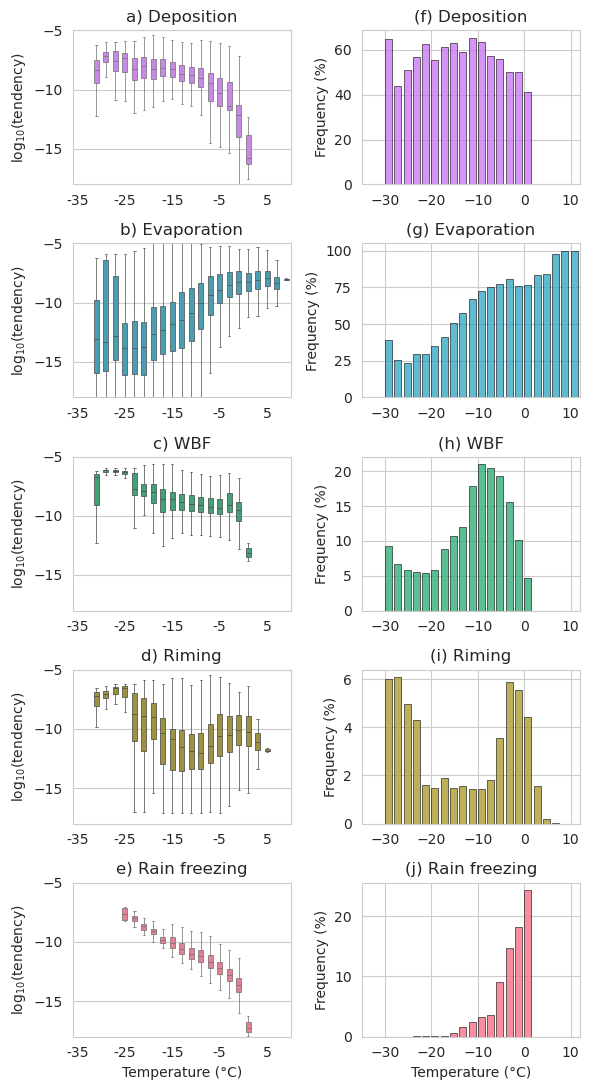

In [18]:
# create for each process a plot showing the mean, and interquartile range for each temperature bin
# use the boxplot function from seaborn. Only use df_fr_tends where deposition > 0  
# the figure should have 2 rows and 3 columns
# use the same temperature bins as before
sns.set_style('whitegrid')

nrows = 5
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(6, 11))
xtick_step = 5


# For liquid processes
for i, process in enumerate(proc_list_sel_T):

    df_sub = df_all_tends[np.abs(df_all_tends[process]) > 0]
    # convert to log scale
    df_sub[process] = np.abs(df_sub[process])
    df_sub[process] = np.log10(df_sub[process])

    bx = sns.boxplot(ax=axes[i,0], x='T_bins', y=process, data=df_sub,
                color=color_map[i], fliersize=1, width=0.5, 
                linewidth=0.5, showfliers=False)
    
    axes[i,0].set_ylim(-18, -5)
    # Set the xticks and labels for every xtick_step element
    axes[i,0].set_xticks(np.arange(0, len(temp_bins_labels), xtick_step))
    axes[i,0].set_xticklabels(temp_bins_labels[::xtick_step])
    axes[i,0].set_title(chr(97+i) + ") "+proc_names_sel_T[i])
    axes[i,0].set_ylabel(r'log$_{10}$(tendency)')
    axes[i,0].set_xlabel('')

    # plot with frequency of occurence
    df_sub = df_all_tends_perc[df_all_tends_perc[process] > 1]
    relative_occ = df_sub['T_bins'].value_counts().sort_index()/df_all_tends_perc['T_bins'].value_counts().sort_index()*100
    axes[i, 1].bar(temp_bins[1:],relative_occ, color=color_map[i], width=1.5,
                    align='edge', edgecolor='black', linewidth=0.5,
                    alpha=0.8, label=process)
    axes[i,1].set_title("(" + chr(97+i+5) + ") "+proc_names_sel_T[i])
    axes[i,1].set_ylabel('Frequency (%)')
    axes[i,1].set_xlabel('')
    axes[i,1].set_xlim(-35, 12)

axes[4,0].set_xlabel('Temperature (°C)')
axes[4,1].set_xlabel('Temperature (°C)')

plt.tight_layout()

plt.savefig(fig_path+'/fig05_proc_vs_temp_pn_pd_revised.pdf', dpi=300,
             bbox_inches='tight', pad_inches=0.1, format='pdf' )

plt.show()


### Figure for appendix

/tmp/ipykernel_3708913/2464230448.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[process] = np.abs(df_sub[process])
/tmp/ipykernel_3708913/2464230448.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[process] = np.log10(df_sub[process])
/tmp/ipykernel_3708913/2464230448.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

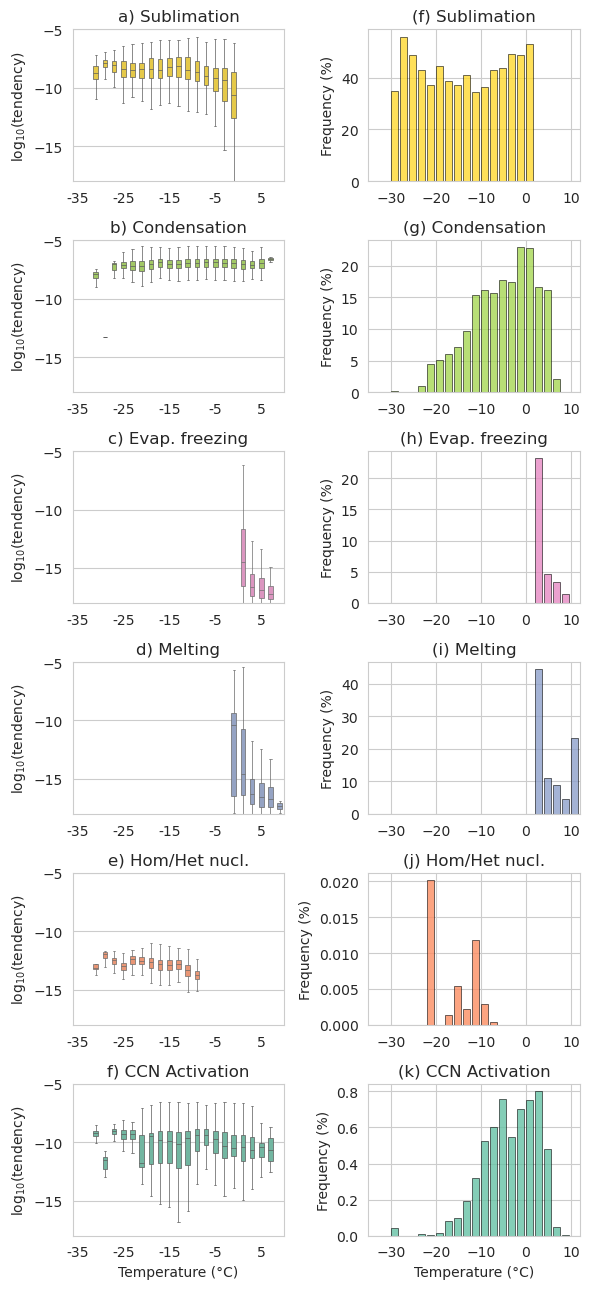

In [25]:
# create for each process a plot showing the mean, and interquartile range for each temperature bin
# use the boxplot function from seaborn. Only use df_fr_tends where deposition > 0  
# the figure should have 2 rows and 3 columns
# use the same temperature bins as before
sns.set_style('whitegrid')

nrows = 6
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(6, 13))
xtick_step = 5

# For liquid processes
for i, process in enumerate(proc_list_sel_T_app):

    df_sub = df_all_tends[np.abs(df_all_tends[process]) > 0]
    # convert to log scale
    df_sub[process] = np.abs(df_sub[process])
    df_sub[process] = np.log10(df_sub[process])

    bx = sns.boxplot(ax=axes[i,0], x='T_bins', y=process, data=df_sub,
                color=color_map_app[i], fliersize=1, width=0.5, 
                linewidth=0.5, showfliers=False)
    
    axes[i,0].set_ylim(-18, -5)
    # Set the xticks and labels for every xtick_step element
    axes[i,0].set_xticks(np.arange(0, len(temp_bins_labels), xtick_step))
    axes[i,0].set_xticklabels(temp_bins_labels[::xtick_step])
    axes[i,0].set_title(chr(97+i) + ") "+proc_names_sel_T_app[i])
    axes[i,0].set_ylabel(r'log$_{10}$(tendency)')
    axes[i,0].set_xlabel('')

    # plot with frequency of occurence
    df_sub = df_all_tends_perc[df_all_tends_perc[process] > 1]
    relative_occ = df_sub['T_bins'].value_counts().sort_index()/df_all_tends_perc['T_bins'].value_counts().sort_index()*100
    axes[i, 1].bar(temp_bins[1:],relative_occ, color=color_map_app[i], width=1.5,
                    align='edge', edgecolor='black', linewidth=0.5,
                    alpha=0.8, label=process)
    axes[i,1].set_title("(" + chr(97+i+5) + ") "+proc_names_sel_T_app[i])
    axes[i,1].set_ylabel('Frequency (%)')
    axes[i,1].set_xlabel('')
    axes[i,1].set_xlim(-35, 12)

axes[5,0].set_xlabel('Temperature (°C)')
axes[5,1].set_xlabel('Temperature (°C)')

plt.tight_layout()

plt.savefig(fig_path+'/C1_proc_vs_temp_pn_pd_appendix.pdf', dpi=300,
             bbox_inches='tight', pad_inches=0.1, format='pdf' )

plt.show()
